In [1]:
# import os
# import sys

import numpy as np
import random as rand
import matplotlib.pyplot as plt
import scipy
import math
import time 
np.seterr(divide='ignore', invalid='ignore')

np.set_printoptions(formatter={'float': '{: 0.8f}'.format})

In [2]:
# Make the plots a bit bigger to see
# NOTE: Must be done in a separate cell
plt.rcParams['figure.dpi'] = 100

In [3]:
#### parameters for simulations ####
parameter = {
    'mx': 40,
    'my': 40,
    'nwarm':200000,
    'nskip':100000,
    'Tc':1.0,
    'coef':0.1,
    'dphi':0.2,
    'gamma':0.05,
    'r0':2.0,
    'Rload':0.5
}

# fo1 = open("randint1.dat", "r")
# fo2 = open("randint2.dat", "r")
# fo3 = open("randn1.dat", "r")
# fo4 = open("randn2.dat", "r")


In [4]:
class Ginz_Landau_FE:
    def __init__(self,parameter,E,Tb,phi,seed):
        self.parameter = parameter
        for iparam,param in parameter.items():
            setattr(self, iparam, parameter[iparam])
#         self.nskip = self.nskip*self.mx*self.my
        self.E = E                                 ## Electric Field added as an input
        self.Tb = Tb                               ## Bath Temperature
        self.phi = phi                             ## Order parameter lattice
        self.ms = np.ones((self.mx,self.my))       ## Mean Field order parameter (to determine Teff)
        self.v0 = np.ones((self.mx,self.my))  
        self.phi_new = np.zeros((self.mx,self.my)) ## Copy of order parameter (may be commented out)
#         self.v0 = disorder*np.random.rand((mx,my)) 
        self.Teff = self.Tb*np.ones((self.mx,self.my)) ## Effective Temperature of the lattice
        self.dx = 1.0      ## Step along X-axis
        self.dy = 1.0      ## Step along Y-axis
        self.Lx = self.dx*(float(self.mx))  ## Length of sample
        self.Ly = self.dy*(float(self.my))  ## Breadth of sample
        self.volt = self.E*self.Ly          ## Volatge bais 
        self.eq_flag = True     ## Flag for equilibriation True --> Warming , False --> Measurement
        self.seed = seed    ## Random Seed
    
    ## Compute Gradient of any 2x2 array (periodic along X, but not Y)
    def gradient(self,f):
        du = np.zeros((self.mx,self.my))
#         for i in range(self.mx):
#             for j in range(self.my):
#                 dg[i,j] = self.grad(f[i,j],i,j)
        du[1:-1,0:] += ( (f[2:,0:] - f[1:-1,0:]) /self.dx)**2 + ((f[0:-2,0:] - f[1:-1,0:])/self.dx)**2 
        du[:,1:-1] += ((f[:,2:] - f[:,1:-1])/self.dy)**2 + ((f[:,0:-2] - f[:,1:-1])/self.dy)**2 
        du[0,:] += ((f[1,:] - f[0,:])/self.dx)**2 + ((f[-1,:] - f[0,:])/self.dx)**2
        du[-1,:] += ((f[0,0:] - f[-1,0:])/self.dx)**2 + ((f[-2,0:] - f[-1,0:])/self.dx)**2
        du[:,0] += ((f[:,1] - f[:,0])/self.dy)**2
        du[:,-1] += ((f[:,-2] - f[:,-1])/self.dy)**2
        return du

    ## Local Gradient
    def grad_phi(self,phi_loc,i,j):
        i1 = (i-1+self.mx)%self.mx
        i2 = (i+1)%self.mx
        dg = ((self.phi[i2,j] - phi_loc)/self.dx)**2 + ((self.phi[i1,j]-phi_loc)/self.dx)**2 
        if j > 0 :
            dg += ((self.phi[i,j-1]-phi_loc)/self.dy)**2
        if j < (self.my-1):
            dg += ((self.phi[i,j+1]-phi_loc)/self.dy)**2    
        return dg

    ## Compute Free Energy as an array
    def free_energy(self):
        term1 = 0.5*((self.Teff/self.Tc) - 1.0)*self.phi**2 
        term2 = 0.5*self.r0*self.gradient(self.phi)
        term3 = 0.25*self.phi**4
        fe = term1 + term2 + term3
        return fe*self.dx*self.dy
    
    ## Local Free Energy computation (Not used but may be used)
    def local_fe(self, phi_loc, Teff_loc, i, j):
        self.phi_new = self.phi_new + self.phi
        self.phi_new[i,j] = phi_loc
        del_phi = self.gradient(self.phi_new)
        fij = 0.5*((Teff_loc/self.Tc) - 1.0)*phi_loc**2 + 0.25*phi_loc**4 + 0.5*self.r0*self.grad_phi(phi_loc,i,j) 
        self.phi_new = np.zeros((self.mx,self.my))
        return fij*self.dx*self.dy
    
    ## Calculating Energy difference between two points on the lattice
    def dfree(self,phi1,Teff1,i,j):
#         print(i,j,phi1,self.phi[i,j])
        df = -0.5*(phi1**2-self.phi[i,j]**2) + 0.25*(phi1**4-self.phi[i,j]**4)
#         print(df)
        df += 0.5*self.r0*(self.grad_phi(phi1,i,j) - self.grad_phi(self.phi[i,j],i,j)) 
#         print(df)
        df += 0.5*Teff1/self.Tc*phi1**2 - 0.5*self.Teff[i,j]/self.Tc*self.phi[i,j]**2
#         print(df)
        return df*self.dx*self.dy

    ## Monte Carlo Loop
    def heatbath_loop(self,f):
        ## set Random Seed
        np.random.seed(self.seed)
        self.seed += 4
        ncount = 0
        iflip = 0
        icount = np.zeros((self.mx,self.my),dtype=int)
        self.ms = self.ms*0.0
        ## set flag
        if(self.eq_flag):
            nsteps = self.nwarm
        else:
            nsteps = self.nskip   
#         print("before :", self.phi)
        for ii in range(0,nsteps):
            i = np.random.randint(0,self.mx)
            j = np.random.randint(0,self.my)
            randummy = np.random.rand()
            ## original order parameter
#             phi0 = self.phi[i,j]
#             Teff0 = self.Teff[i,j]
#             f0 = self.local_fe(phi0,Teff0,i,j) 
            ## new order parameter
            phi1 = self.phi[i,j] + 2.0*self.dphi*(np.random.rand() - 0.5)
#             phi1 = self.phi[i,j] + np.random.uniform(-self.dphi,self.dphi)
            Teff1 = self.Teff[i,j]
#             f1 = self.local_fe(phi1,Teff1,i,j)
            ## computing the differnce in energy
            df = self.dfree(phi1,Teff1,i,j)
            icount[i,j] += 1
            ncount += 1
            ## MC MC step
            if randummy < np.exp(-df/self.Tb):
                self.phi[i,j] = phi1     
                self.Teff[i,j] = Teff1
                f += df
                iflip += 1
            self.ms[i,j] += self.phi[i,j]    
         
        self.ms = np.where(icount == 0, self.phi , self.ms/icount)        
        rate = float(iflip)/float(ncount) 
        return self.phi, self.Teff, self.ms, f

    ## Compute Effective Temperature    
    def setTeff(self):
        tbath = self.Tb*np.ones((self.mx,self.my))
        gam = self.gamma*np.ones((self.mx,self.my))
        efield = self.coef*self.E*np.ones((self.mx,self.my))
        return np.sqrt(tbath**2 + efield**2/(gam**2 + self.ms**2) )
    
    ## Compute Averages
    def averages(self,f):
        ave_phi = np.mean(self.phi)
#         std_phi = np.std(self.phi)
        ave_phi2 = np.mean(self.phi**2)
        std_phi2 = np.std(self.phi**2)
        ave_fe = f/(self.mx*self.my)
        std_fe = np.sqrt((f**2 - ave_fe**2)/(self.mx*self.my))
        ave_teff = np.mean(self.Teff)
        return std_fe, ave_phi, ave_fe, ave_teff, ave_phi2, std_phi2
    
    ## Function initiating the Warming of the lattice
    def warming(self):
        self.Teff = self.setTeff()
        f = np.sum(self.free_energy())
        self.phi, self.Teff, self.ms, f = self.heatbath_loop(f) 
        return self, f
    
    ## Function intiating the production runs and gives out the measurements
    def meas(self,f):
        self.eq_flag = False
        self.Teff = self.setTeff()
        f = np.sum(self.free_energy())
        self.phi, self.Teff, self.ms, f = self.heatbath_loop(f)
        std_fe, ave_phi, ave_fe, ave_teff, ave_phi2, std_phi2 = self.averages(f)
        ft = self.free_energy()
        return std_fe, ave_phi, ave_fe, ave_teff, ave_phi2, std_phi2, ft.flatten(), self.phi
        
    
           

In [5]:
nmeas = 8 
print(parameter)
Mx = parameter["mx"]
My = parameter["my"]
Tbvals = np.arange(0.01,1.01,0.01)
# Tbvals = np.append(Tbvals,Tbvals[::-1])
ndata = np.size(Tbvals)
print("Tbvals :",Tbvals)
E = 0.0
Data_Set = np.zeros((ndata,8))
# check_data = np.zeros((ndata,3))
k = 0
phit = np.ones((Mx,My),dtype=np.float64)
seed = 4546
for Tb in Tbvals: 
#     start = time.time()
    glt = Ginz_Landau_FE(parameter,E,Tb,phit,seed)
    fm = glt.warming()
    Data_Set[k,0] = Tb
    for i in range(0,nmeas):
        f2 , delta, f , teff , ohm, ohm2, ft, phit = glt.meas(fm)
        Data_Set[k,1:8] += [delta , ohm - delta**2 , f, f2 , ohm, ohm2, teff]
        
    Data_Set[k,1:8] = Data_Set[k,1:8]/nmeas
#     time1 = time.time() - start
#     check_data[k,:] = [Mx, My, time1]
    print(Data_Set[k,:])    
    k += 1 
    seed += 1

# np.savetxt("delta_py_40x40.dat",Data_Set)
# np.savetxt("time2_data_80.dat",check_data)


{'mx': 40, 'my': 40, 'nwarm': 200000, 'nskip': 100000, 'Tc': 1.0, 'coef': 0.1, 'dphi': 0.2, 'gamma': 0.05, 'r0': 2.0, 'Rload': 0.5}
Tbvals : [ 0.01000000  0.02000000  0.03000000  0.04000000  0.05000000  0.06000000
  0.07000000  0.08000000  0.09000000  0.10000000  0.11000000  0.12000000
  0.13000000  0.14000000  0.15000000  0.16000000  0.17000000  0.18000000
  0.19000000  0.20000000  0.21000000  0.22000000  0.23000000  0.24000000
  0.25000000  0.26000000  0.27000000  0.28000000  0.29000000  0.30000000
  0.31000000  0.32000000  0.33000000  0.34000000  0.35000000  0.36000000
  0.37000000  0.38000000  0.39000000  0.40000000  0.41000000  0.42000000
  0.43000000  0.44000000  0.45000000  0.46000000  0.47000000  0.48000000
  0.49000000  0.50000000  0.51000000  0.52000000  0.53000000  0.54000000
  0.55000000  0.56000000  0.57000000  0.58000000  0.59000000  0.60000000
  0.61000000  0.62000000  0.63000000  0.64000000  0.65000000  0.66000000
  0.67000000  0.68000000  0.69000000  0.70000000  0.7100

[ 0.70000000  0.01883318  0.16833939  0.66255462  26.50217963  0.16963537
  0.22741354  0.70000000]
[ 0.71000000  0.02596219  0.18149530  0.67208064  26.88322041  0.18302408
  0.23959571  0.71000000]
[ 0.72000000 -0.04689157  0.17153391  0.66262860  26.50513886  0.17399533
  0.23067876  0.72000000]
[ 0.73000000  0.00074526  0.17721831  0.69303617  27.72144125  0.17753639
  0.23730886  0.73000000]
[ 0.74000000  0.02770553  0.16553505  0.70688779  28.27550616  0.16732066
  0.22547781  0.74000000]
[ 0.75000000  0.01920103  0.17407263  0.70252510  28.10099833  0.17528807
  0.23190228  0.75000000]
[ 0.76000000 -0.04223066  0.17193749  0.69104260  27.64169841  0.17399855
  0.23197060  0.76000000]
[ 0.77000000  0.00574838  0.17913268  0.73717426  29.48696445  0.17936828
  0.23919645  0.77000000]
[ 0.78000000  0.03170255  0.16698253  0.74489857  29.79593684  0.16901258
  0.23033145  0.78000000]
[ 0.79000000  0.03280420  0.17509795  0.73996376  29.59854456  0.17742139
  0.23183056  0.79000000]


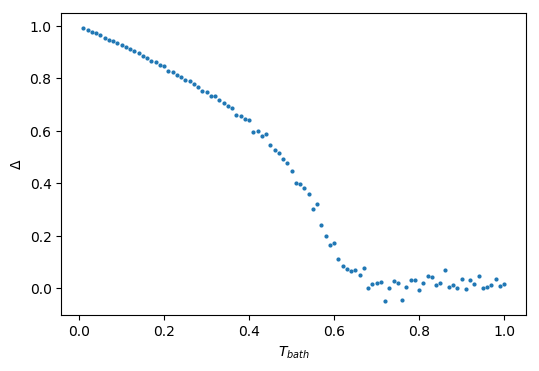

In [6]:
plt.scatter(Data_Set[:,0],Data_Set[:,1], s = 4.0)
# plt.plot(Data_Set[:,0],Data_Set[:,1])
plt.xlabel(r'$T_{bath}$')
plt.ylabel(r'$\Delta$')
# plt.xticks(np.arange(0, 1, step=0.1))
# plt.yticks(np.arange(-0.1, 1, step=0.1))
plt.show()

In [7]:
#     def dfree(self,phi1,Teff1,i,j):
#         phi_new = self.phi
#         phi_new[i,j] = phi1
#         del_phi1 = self.gradient(phi_new)
#         del_phi0 = self.gradient(self.phi)
        
#         df = -0.5*(phi1**2-self.phi[i,j]**2) + 0.5*Teff1/self.Tc*phi1**2 - 0.5*self.Teff[i,j]/self.Tc*self.phi[i,j]**2
#         df += 0.25*(phi1**4-self.phi[i,j]**4)
#         df += 0.5*self.r0*(del_phi1[i,j] - del_phi0[i,j])
#         return df*self.dx*self.dy


In [8]:
#             i = int(fo1.readline())
#             j = int(fo2.readline())
#             randummy1 = float(fo3.readline())
#             randummy2 = float(fo4.readline())
#             phi1 = self.phi[i,j] + 2.0*self.dphi*(randummy1 - 0.5)

